In [1]:
import sys
import os

path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)

import ising
import os
import sys
import time

os.chdir("..")
os.getcwd()

import preprocessing as pre
import model_eval as eval
import utils as utils
import misc_plotting as misc_plotting
import isingfitter as fitter

import numpy as np
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pandas as pd
import tqdm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import seaborn as sns
sns.set_theme()
sns.set_style(rc = {'axes.facecolor': '#e5ecf6'})

In [187]:
def get_coords2units_map(L):
    coords2units = np.arange(0, L**2)
    return coords2units.reshape((L,L))

def units2lattice_coords(idx, L):
    coords2units = get_coords2units_map(L)
    (x, y) = np.where(coords2units == idx)
    return (x[0], y[0])

def lattice_coords2units(x, y, L):
    coords2units = get_coords2units_map(L)
    return coords2units[x,y]

def are_axis_neighbors(x1, x2, L):
   return (x1 == (x2 + 1) % L or x1 == (x2 - 1) % L)

def are_neighbours(i,j, L):
    x1, y1 = units2lattice_coords(i, L)
    x2, y2 = units2lattice_coords(j, L)
    cond1 = (x1 == x2 and are_axis_neighbors(y1, y2, L))
    cond2 = (y1 == y2 and are_axis_neighbors(x1, x2, L))

    if (cond1 or cond2):
        return True
    return False
    
def get_periodic_2d_ising_couplings(L, J):
    num_units = L * L
    couplings = np.zeros((num_units, num_units))
    
    for i in range(num_units):
        for j in range(i + 1, num_units):
            if are_neighbours(i, j, L):
                couplings[i, j] = J
                couplings[j, i] = J
    return couplings
        
def get_av_magnetization(states):
    N, num_bins = states.shape
    m_av = np.sum(np.abs(np.sum(states, axis=0)) / N)
    return m_av / num_bins

def get_av_susceptibility(states, T):
    N = states.shape[0]
    M = np.sum(states, axis=0) # array of length num_bins
    M_av = np.mean(M)
    M_sq_av = np.mean(M ** 2)
    return (M_sq_av - M_av ** 2) / (T * N)

def get_order_param(states):
    num_bins = states.shape[1]
    num_up = np.zeros(shape=num_bins)
    num_down = np.zeros(shape=num_bins)

    for t in range(num_bins):
        num_up[t] = len(np.where(states[:,t]==1)[0])
        num_down[t] = len(np.where(states[:,t]==-1)[0])

    num_spins = states.shape[0]
    return np.mean(np.abs(num_up - num_down) / num_spins * np.ones(num_bins))


In [224]:

Ls = [4, 8]

temp_range = np.concatenate([
np.linspace(0.05, 1.5, 50),
np.linspace(1.5, 2.5, 100),
np.linspace(2.5, 5, 50),
])
num_temps = len(temp_range)
num_runs = 3

magnetizations = dict( (L, np.zeros((num_runs, num_temps))) for L in Ls)
susceptibilities = dict( (L, np.zeros((num_runs, num_temps))) for L in Ls)

for L in Ls:
    print(f"L = {L}")
    num_units = int(L*L)
    for run in range(num_runs):
        print(f"Run: {run+1}/{num_runs}")
        for t in tqdm.tqdm(range(num_temps)):
            T = temp_range[t]
            beta = 1 / T
            J = get_periodic_2d_ising_couplings(L, J=beta)
            h = np.zeros(num_units)
            model = ising.EqModel(J, h)
            if T < 1:
                num_sims = 1_000_000
                num_burn = 100_000
            else:
                num_sims = 15_000
                num_burn = 5_000
            
            sample = model.simulate(num_sims, num_burn)

            M = get_av_magnetization(sample.getStates())
            chi = get_av_susceptibility(sample.getStates(), T)

            magnetizations[L][run, t] = M
            susceptibilities[L][run, t] = chi
    

L = 4
Run: 1/3


100%|██████████| 200/200 [00:07<00:00, 28.54it/s] 


Run: 2/3


100%|██████████| 200/200 [00:06<00:00, 30.09it/s] 


Run: 3/3


100%|██████████| 200/200 [00:06<00:00, 30.07it/s] 


L = 8
Run: 1/3


100%|██████████| 200/200 [00:25<00:00,  7.90it/s]


Run: 2/3


100%|██████████| 200/200 [00:26<00:00,  7.69it/s]


Run: 3/3


100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


In [225]:
av_mag = dict((L, np.mean(magnetizations[L], axis=0)) for L in Ls)
sd_mag = dict((L, np.std(magnetizations[L], axis=0)) for L in Ls)

av_chi = dict((L, np.mean(susceptibilities[L], axis=0)) for L in Ls)
sd_chi = dict((L, np.std(susceptibilities[L], axis=0)) for L in Ls)

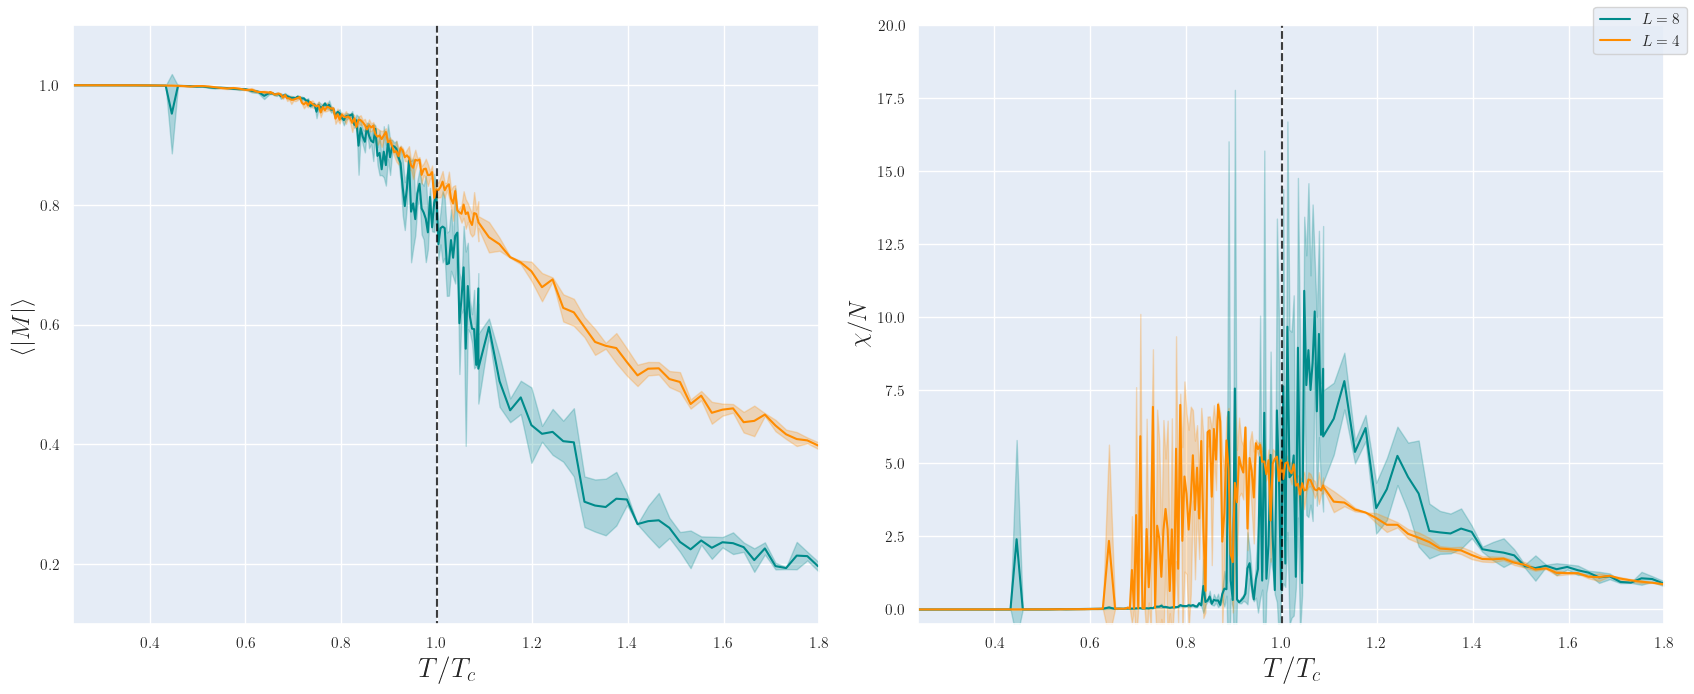

In [234]:
xmin = 0.24
xmax = 1.8
color = "darkorange"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,7))

color = ["darkorange", "darkcyan", "blueviolet", "limegreen"]
colors = dict(
    (Ls[i], color[i]) for i in range(len(Ls))
)
for L in Ls[::-1]:
    ax[0].fill_between(x=temp_range / 2.3, y1=av_mag[L] +sd_mag[L], y2 = av_mag[L] - sd_mag[L], alpha=.25, color=colors[L])
    ax[0].plot(temp_range / 2.3, av_mag[L], color=colors[L])
    ax[0].set_ylabel(r'$\langle |M| \rangle$', fontsize=18)
    ax[0].vlines(x=[1], ymin=-.5, ymax=1.2, color="black", linestyle="--", alpha=.5)
    
    ax[0].set_xlim([xmin,xmax])
    ax[0].set_ylim([0.1,1.1])
    ax[0].set_xlabel('$T/T_c$', fontsize=20)


    ax[1].fill_between(x=temp_range / 2.3, y1=av_chi[L] + sd_chi[L], y2 = av_chi[L] - sd_chi[L], alpha=.25, color=colors[L])
    ax[1].plot(temp_range / 2.3, av_chi[L], color=colors[L], label=rf"$L = {L}$")
    ax[1].set_ylabel(r'$\chi / N$', fontsize=18)
    ax[1].vlines(x=[1], ymin=-.5, ymax=30, color="black", linestyle="--", alpha=.5)

    ax[1].set_ylim([-.5,20])
    ax[1].set_xlim([xmin,xmax])
    ax[1].set_xlabel('$T/T_c$', fontsize=20)

   

fig.legend()
fig.tight_layout()
#fig.suptitle('$T/T_c$', fontsize=20, y = 0.001)

plt.savefig("phase_transition.pdf")

plt.show()


<Figure size 640x480 with 0 Axes>